# SNUH-NVIDIA  MONAI Bootcamp -  End-To-End Workflow with MONAI

<img src="https://github.com/Project-MONAI/MONAIBootcamp2021/raw/2f28b64f814a03703667c8ea18cc84f53d6795e4/day1/monai.png" width=400>

Welcome to the MONAI bootcamp! This notebook will introduce you to an end-to-end workin in MONAI using both a standard PyTorch loop and using Ignite, followed by a hands-on implementing your own model using everything you've learned so far.

#### Required Packages 
The servers running MONAI Bootcamp already have CUDA driver, CUDA toolkit 11.0, pytorch 1.6+, monai 0.8.1, and libraries for practice installed.

This notebook has the pip command for installing MONAI and will be added to any subsequent notebook in BYOD or colab environment.

Execute the following cell to install MONAI the first time a colab notebook is run:

In [ ]:
#!pip install -qU "monai-weekly[all]"

### Check GPU Support

Running `!nvidia-smi` in a cell will verify this has worked and show you what kind of hardware you have access to.

In [1]:
!nvidia-smi

Mon Aug 21 07:10:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:07:00.0 Off |                   On |
| N/A   30C    P0    52W / 400W |     39MiB / 81920MiB |     N/A      Default |
|                               |                      |              Enabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:0F:00.0 Off |                   On |
| N/A   

# End-to-end Training with Pytorch and Ignite
We've covered a lot of material and now it's time to apply the things that we've learned in an end-to-end example. First, we're going to use the basic PyTorch paradigm for training our model. We'll then look at how to train using the Ignite workflows to make things even easier!

## End-to-End Training Workflow
To help guide you through training your first model using MONAI, this guide will will cover five key phases:

 1. Setting up our Dataset and exploring the data
 2. Preparing datasets and transforms
 3. Define your network and create our PyTorch training loop
 4. Evaluate your model and understand the results
 5. Start using Ignite and more about determinism
 
Let's get started by importing our dependencies.

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import monai

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.data import decollate_batch, partition_dataset_classes
from monai.networks.nets import DenseNet121
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    Activations,
    AsDiscrete,
    EnsureType
)
from monai.utils import set_determinism

Environment variable `TORCH_ALLOW_TF32_CUBLAS_OVERRIDE = 1` is set.
  This environment variable may enable TF32 mode accidentally and affect precision.
  See https://docs.monai.io/en/latest/precision_accelerating.html#precision-and-accelerating


## 1. Setting up our Dataset and exploring the data
#### Setup data directory
 

In [3]:
import os 
root_dir = './dataset'
print(root_dir)

./dataset


Download the MedNIST dataset
The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions), [the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4), and the [NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic) under the Creative Commons CC BY-SA 4.0 license. If you use the MedNIST dataset, please acknowledge the source.

We're going to download this dataset below and extract it into our temporary MONAI Data Directory.
It will take about 1 minute

In [4]:
%%time

resource = "https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz?dl=1"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

MedNIST.tar.gz: 59.0MB [00:06, 10.3MB/s]                              


2023-08-21 07:11:26,532 - INFO - Downloaded: dataset/MedNIST.tar.gz
2023-08-21 07:11:26,635 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-08-21 07:11:26,637 - INFO - Writing into directory: ./dataset.
CPU times: user 5.61 s, sys: 22.5 s, total: 28.1 s
Wall time: 1min 26s


### Set deterministic training for reproducibility

[`set_determinism`](https://docs.monai.io/en/latest/utils.html?highlight=set_determinism#monai.utils.misc.set_determinism) will set the random seeds in both Numpy and PyTorch to ensure reproducibility. We'll see later that we need to go a little bit further to ensure reproducibility in a jupyter notebook

In [5]:
set_determinism(seed=0)

#### Read the image filenames from the dataset folders

When using a dataset, you want to understand the basics of the images, labels, and more. We'll start off by showing some of those basic statistics for MedNIST.

We'll see that 6 different folders are representing 6 different categories: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT. We'll be using each of these categories as our label names.

In [6]:
class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)

image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]

num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []

for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
    
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"number of Labels: {num_class}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
number of Labels: 6
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


## Randomly pick images from the dataset to visualize and check
We want to understand what the images we're using look like, so we'll start by visualizing a few random images.

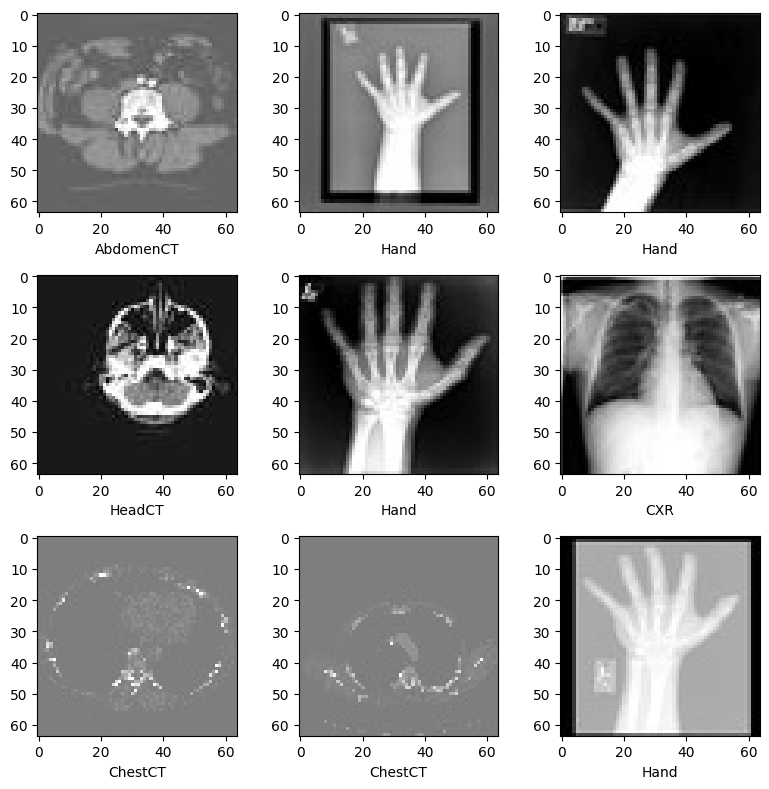

In [7]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

# 2. Preparing datasets and transforms
### Prepare training, validation, and test data lists

We want to split the data into 3 different sets, one for training, one for validation, and one for testing. We'll use a ratio of 80/10/10 for those sets.

In [8]:
val_frac = 0.1
test_frac = 0.1
train_x = list()
train_y = list()
val_x = list()
val_y = list()
test_x = list()
test_y = list()

for i in range(num_total):
    rann = np.random.random()
    if rann < val_frac:
        val_x.append(image_files_list[i])
        val_y.append(image_class[i])
    elif rann < test_frac + val_frac:
        test_x.append(image_files_list[i])
        test_y.append(image_class[i])
    else:
        train_x.append(image_files_list[i])
        train_y.append(image_class[i])

print(f"Training count: {len(train_x)}, Validation count: {len(val_x)}, Test count: {len(test_x)}")

Training count: 47156, Validation count: 5913, Test count: 5885


### Define MONAI transforms, Dataset and Dataloader to pre-process data

We'll define our transform using `Compose`. In this Array of Transforms, we'll load the image, add a channel, scale its intensity, utilize a few random functions and finally create a tensor.

#### Assessment 1 transform 
Below you'll define the Compose trainsform train for the training data. You'll need the following transforms:

Load Image
Ensure Channel First
Scale Intensity
Random Rotate, Flip, and Zoom

In [ ]:
rseed = 12345678

train_transforms = Compose(
    [ ??? ]
)

val_transforms = Compose(
    [ ??? ]
)

act = Compose([Activations(softmax=True)])
to_onehot = Compose([AsDiscrete(to_onehot=num_class)])

##### solution

In [10]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=15, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5) 
    ]
)

val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity() ])

act = Compose([EnsureType(), Activations(softmax=True)])
to_onehot = Compose([EnsureType(), AsDiscrete(to_onehot=num_class, n_classes=num_class)])

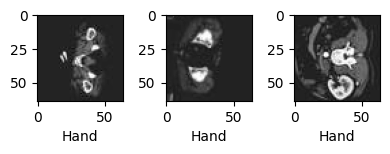

In [11]:
### Transform Test Functionality
plt.subplots(1, 3, figsize=(4, 4))
for i in range(0,3):
    test_output = train_transforms(image_files_list[i])
    #test_output = val_transforms(image_files_list[i])    
    
    arr = np.array(test_output[0])
    plt.subplot(1, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=1)
plt.tight_layout()
plt.show()

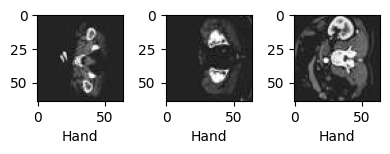

In [12]:
### Transform Test Functionality
plt.subplots(1, 3, figsize=(4, 4))
for i in range(0,3):
    #test_output = train_transforms(image_files_list[i])
    test_output = val_transforms(image_files_list[i])    
    
    arr = np.array(test_output[0])
    plt.subplot(1, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=1)
plt.tight_layout()
plt.show()

### Initialise the datasets and loaders for training, validation and test sets
- Define a simple dataset, that we'll call `MedNISTDataset`, that  groups:

 - Images
 - Labels
 - The transforms that are to be run on the images and labels
- Create three instances of this dataset:
  - One for training
  - One for validation
  - One for testing

We'll use a batch size of 512 and employ 10 workers to load the data.

In [19]:
batch_size = 512
num_workers = 10

class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)

3. Define your network and create our PyTorch training loop
Define network and optimizer
Set learning_rate for how much the model is updated per step
The fetch a pytorch device for the GPU
Instantiate a `densenet121` model instance and 'send' it to the GPU using device
This is a standard MONAI implementation; it is capable of 2D and 3D operation but here we are using it in 2D mode
We'll make use of the Adam optimizer

#### Assessment configure 

Do the following:

- Get the device for a GPU from torch
- Instantiate DenseNet121. You'll need to set Spatial Dimension to 2 and Input Channels to 1 and output channels to the number of classes from our data exploration above.
- Instantiate the Torch CrossEntropy Loss function
- Instantiate the Torch Adam Optimizer with a learning rate of 1e-5

In [ ]:
device = ???  ### TODO 
net = ???   #### TODO
loss_function = ??? #### TODO
optimizer = ??? #### TODO

In [22]:
learning_rate = 1e-5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = DenseNet121(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), learning_rate)

#### Network training

We are hand-rolling a basic pytorch training loop here:

standard pytorch training loop
step through each training epoch, running through the training set in batches
after each epoch, run a validation pass, evaluating the network
if it shows improved performance, save out the model weights
later we will revisit training loops in a more Ignite / MONAI fashion

In [23]:
epoch_num = 4
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
auc_metric = ROCAUCMetric()

for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")

    epoch_loss = 0
    step = 1

    steps_per_epoch = len(train_ds) // train_loader.batch_size

    # put the network in train mode; this tells the network and its modules to
    # enable training elements such as normalisation and dropout, where applicable
    net.train()
    for batch_data in train_loader:

        # move the data to the GPU
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)

        # prepare the gradients for this step's back propagation
        optimizer.zero_grad()
        
        # run the network forwards
        outputs = net(inputs)
        
        # run the loss function on the outputs
        loss = loss_function(outputs, labels)
        
        # compute the gradients
        loss.backward()
        
        # tell the optimizer to update the weights according to the gradients
        # and its internal optimisation strategy
        optimizer.step()

        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size + 1}, training_loss: {loss.item():.4f}")
        step += 1

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # after each epoch, run our metrics to evaluate it, and, if they are an improvement,
    # save the model out
    
    # switch off training features of the network for this pass
    net.eval()

    # 'with torch.no_grad()' switches off gradient calculation for the scope of its context
    with torch.no_grad():
        # create lists to which we will concatenate the the validation results
        preds = list()
        labels = list()

        # iterate over each batch of images and run them through the network in evaluation mode
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)

            # run the network
            val_pred = net(val_images)

            preds.append(val_pred)
            labels.append(val_labels)

        # concatenate the predicted labels with each other and the actual labels with each other
        y_pred = torch.cat(preds)
        y = torch.cat(labels)

        # we are using the area under the receiver operating characteristic (ROC) curve to determine
        # whether this epoch has improved the best performance of the network so far, in which case
        # we save the network in this state
        y_onehot = [to_onehot(i) for i in decollate_batch(y, detach=False)]        
        y_pred_act = [act(i) for i in decollate_batch(y_pred)]
        
        auc_metric(y_pred_act, y_onehot)
        auc_value = auc_metric.aggregate()
        auc_metric.reset()
        metric_values.append(auc_value)
        
        acc_value = torch.eq(y_pred.argmax(dim=1), y)
        acc_metric = acc_value.sum().item() / len(acc_value)
        
        if auc_value > best_metric:
            best_metric = auc_value
            best_metric_epoch = epoch + 1
            torch.save(net.state_dict(), os.path.join(root_dir, "mednist_model_best.pth"))
            print("saved new best metric network")
            
        print(
            f"current epoch: {epoch + 1} current AUC: {auc_value:.4f} /"
            f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f} /"
            f" at epoch: {best_metric_epoch}"
        )

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/4
1/93, training_loss: 1.8461
2/93, training_loss: 1.8182
3/93, training_loss: 1.7915
4/93, training_loss: 1.7725
5/93, training_loss: 1.7563
6/93, training_loss: 1.7101
7/93, training_loss: 1.6824
8/93, training_loss: 1.6758
9/93, training_loss: 1.6378
10/93, training_loss: 1.6143
11/93, training_loss: 1.6221
12/93, training_loss: 1.5616
13/93, training_loss: 1.5549
14/93, training_loss: 1.5314
15/93, training_loss: 1.5026
16/93, training_loss: 1.4703
17/93, training_loss: 1.4638
18/93, training_loss: 1.4098
19/93, training_loss: 1.4229
20/93, training_loss: 1.4116
21/93, training_loss: 1.3620
22/93, training_loss: 1.3599
23/93, training_loss: 1.3187
24/93, training_loss: 1.3065
25/93, training_loss: 1.2879
26/93, training_loss: 1.2691
27/93, training_loss: 1.2501
28/93, training_loss: 1.2525
29/93, training_loss: 1.2373
30/93, training_loss: 1.2142
31/93, training_loss: 1.2029
32/93, training_loss: 1.1659
33/93, training_loss: 1.1584
34/93, training_loss: 1.1561
35

### Plot the loss and metric
Once we're done training we want to visualize our Loss and Accuracy.

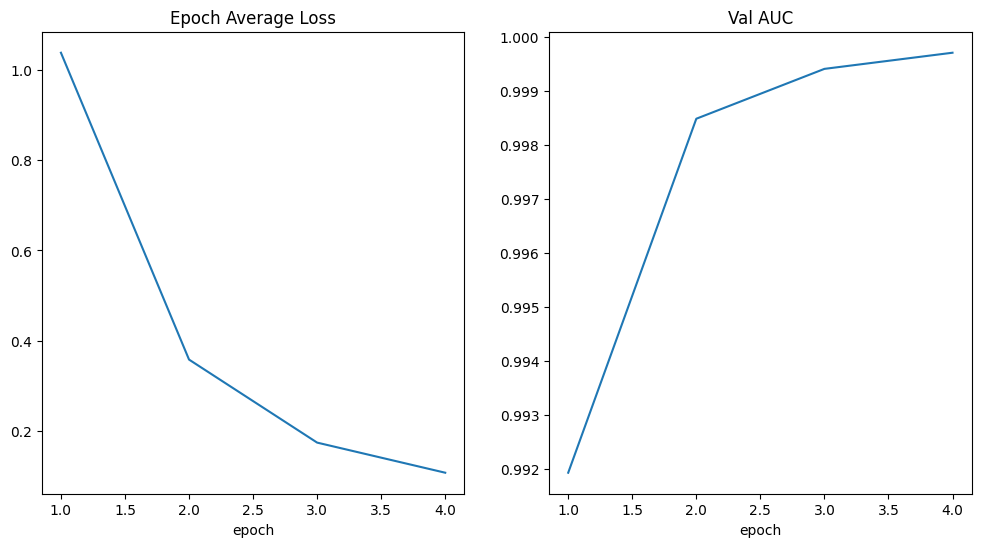

In [24]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [(i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## 4. Evaluate your model and understand the results
### Evaluate the model on the test dataset

After training and validation, we now have the best model as determined by the validation dataset. But now we need to evaluate the model on the test dataset to check whether the final model is robust and not over-fitting. We'll use these predictions to generate a classification report.

In [25]:
#net.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
net.load_state_dict(torch.load(os.path.join(root_dir, "mednist_model_best.pth")))
net.eval()
y_true = list()
y_pred = list()

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = net(test_images).argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

### Some light analytics - classification report

We'll utilize scikit-learn's classification report to get the precision, recall, and f1-score for each category.

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9783    0.9752    0.9767       969
   BreastMRI     0.9936    0.9883    0.9910       944
         CXR     0.9938    0.9825    0.9881       973
     ChestCT     0.9887    1.0000    0.9943       959
        Hand     0.9839    0.9867    0.9853      1055
      HeadCT     0.9798    0.9848    0.9823       985

    accuracy                         0.9862      5885
   macro avg     0.9863    0.9863    0.9863      5885
weighted avg     0.9863    0.9862    0.9862      5885



### Some light analytics - confusion matrix

Let's also create a confusion matrix to get a better understanding of the failure cases

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


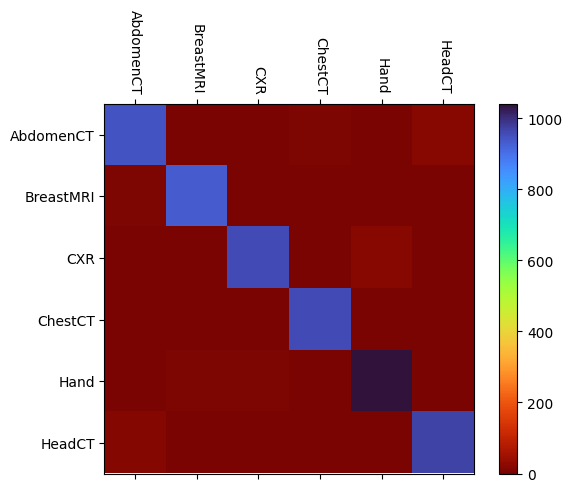

In [33]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true, y_pred)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix(y_true, y_pred), cmap="turbo_r", interpolation='nearest')
fig.colorbar(cax)

ax.set_xticklabels(['']+class_names, rotation=270)
ax.set_yticklabels(['']+class_names)

plt.show()

## Caution !!!
### please shutdown all kernels with [Kernel] menu >  [Shutdown All Kernel]  before launch next notebook

## Navigation

- [01 MONAI transform](./01_getting.ipynb)
- [02_end_to_end_pipeline](./02_end_to_end_pipeline.ipynb)
- [03_spleen_segment](./03_spleen_segment.ipynb)
- [04_Auto3DSeg](./04_Auto3DSeg.ipynb)
- [05_Auto3DSeg_hippocampus](./05_Auto3DSeg_hippocampus.ipynb)
- [06_digital_pathology_wsi](./06_digital_pathology_wsi.ipynbb)
- [07_HoverNet_01_inference](./07_HoverNet_01_inference.ipynb)
- [08_HoverNet_02_train](./08_HoverNet_02_train.ipynb)



<img src="https://github.com/Project-MONAI/MONAIBootcamp2021/raw/2f28b64f814a03703667c8ea18cc84f53d6795e4/day1/monai.png" width=400>